In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import shutil

from easydict import EasyDict
from tqdm import tqdm

import scipy as sp
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold  # 交叉验证
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

#import loss_func
from torch.cuda.amp import autocast, GradScaler
import warnings

warnings.filterwarnings('ignore')

In [2]:
CFG = EasyDict({
    "model_name":"efficientnet_b5",
    "num_class": 10,
    "image_size":(32,32),
    "pretrained":True,
    "epochs":5,
    "batch_size":64,
    "num_workers":0,
    "device":"cpu",
    "size_h": 224,
    "size_w": 224,
    "lr":3e-4,
    "weight_decay":1e-6,
    
})

# 数据读取

In [3]:
train = pd.read_csv("./Data/BoolArt/train.csv")
train

,id,target
0,15970,0
1,59263,4
2,21379,3
3,1855,0
4,30805,0
...,...,...
35546,17036,1
35547,6461,11
35548,18842,0
35549,46694,8


In [4]:
# ====================================================
# Dataset 
# ====================================================
class TrainDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df
        self.file_names = df['id'].values # 获取图片文件名
        self.labels = df['target'].values # 获取训练集图片target值
        self.transform = transform
        
    def __len__(self):  # len(train_dataset) 调用
        return len(self.df)
    
    # 读取图片
    def __getitem__(self,idx): # 这里的idx如何读取呢？---通过 [num] 正常传入序号
        self.file_path = f'./Data/BoolArt/train_image/{self.file_names[idx]}.jpg' # 读取图片地址
        image = np.array(Image.open(self.file_path).convert("RGB"))
        
        
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = cv2.resize(image,(CFG.size_h,CFG.size_w)) # 和原码不一样
#             image = image[np.newaxis,:,:] # 添加一个新的轴
            image = torch.from_numpy(image).float() #  ndarray -> pytorch
            
        label = torch.tensor(self.labels[idx]).long() # tensor
        
        return image/255, label

In [5]:
train_dataset = TrainDataset(train)


In [6]:
train_dataset.file_names

array([15970, 59263, 21379, ..., 18842, 46694, 51623], dtype=int64)

In [7]:
train_dataset.labels

array([0, 4, 3, ..., 0, 8, 4], dtype=int64)

In [8]:
len(train_dataset)

35551

In [9]:
image,label = train_dataset[5] # 读取__getitem__返回的image/225,label

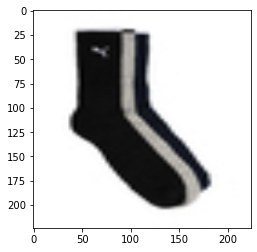

In [10]:
plt.imshow(image.reshape(224,224,3))  # h,w,in_chans

In [11]:
label

tensor(13)

## transform

In [12]:
def get_transform(*,data):
    if data == 'train':
        return A.Compose([
            
            A.Resize(CFG.size_w, CFG.size_h),
            A.HorizontalFlip(p=0.5), # 水平翻转
            A.VerticalFlip(p=0.5),   # 垂直翻转
#             A.RandomBrightnessContrast(p=0.2), 
            ToTensorV2()  # 把数据转化为Pytorch格式
        ])
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size_w, CFG.size_h),
            ToTensorV2()  # 把数据转化为Pytorch格式
        ])

## 数据集定义
- 全部训练集
- 划分出来的用于训练的训练集
- 划分出来用于验证的验证集

In [13]:
full_train_ds = TrainDataset(train)
train_ds = TrainDataset(train[:28440],transform=get_transform(data='train'))
valid_ds   = TrainDataset(train[28440:],transform=get_transform(data='valid'))

train_loader = DataLoader(train_ds,batch_size=CFG.batch_size,pin_memory=True,drop_last=False)
valid_loader = DataLoader(valid_ds,batch_size=CFG.batch_size*2,pin_memory=True,drop_last=False)

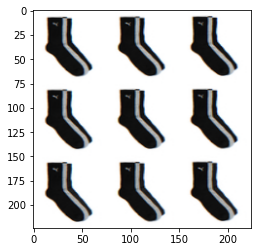

In [14]:
# 查看transform后的图片
image,label = train_ds[5] 
plt.imshow(image.reshape(224,224,3))

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'13'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'12'}>,
       <AxesSubplot:title={'center':'11'}>,
       <AxesSubplot:title={'center':'11'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'9'}>,
       <AxesSubplot:title={'center':'32'}>,
       <AxesSubplot:title={'center':'8'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'0'}>,
      

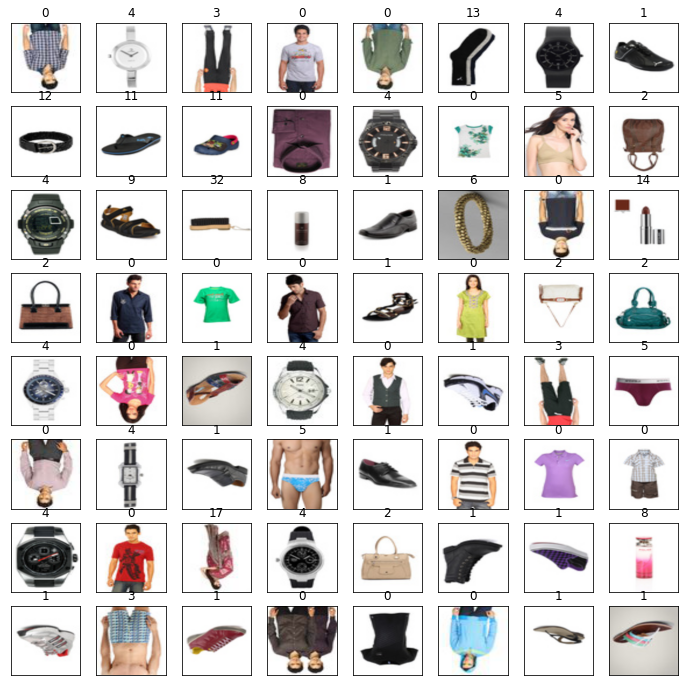

In [15]:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize = (num_cols*scale,num_rows*scale)
    
    # 创建一个包含 num_rows行，num_cols列 的子图， figsize是显示绘图窗口的大小
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)  # axes 轴
    axes = axes.flatten()
    
    for i, (ax,img) in enumerate(zip(axes,imgs)): # ax-一张图的轴 img-一张图的数据值
        if torch.is_tensor(img):
            # 图片张量
            img = img.permute(1,2,0).numpy()*255
            ax.imshow(img.astype(np.uint8))
        else:                
            # PIL图片--这个数据集
            ax.imshow(img) # 把img画在ax底图上
        ax.axes.get_xaxis().set_visible(False) # set_visible(False) 隐藏坐标轴
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(y[i].item()) # 迭代y 在一个batch_size中
    return axes

X, y = next(iter(train_loader))  # X 为一个batch_size的图片的array， y为label
show_images(X, 8, 8, y) # 显示一个batch_size,且返回值为axes的值，也就是下面这些图片

# Model

In [16]:
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=3)
        #print(self.model)
        
        if 'efficientnet' in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features
            self.model.global_pool = nn.Identity()
            self.model.classifier = nn.Identity()
            
        elif 'resnet' in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
                            #nn.Conv2d(self.n_features, self.n_features // 8, 1),
                            #nn.LeakyReLU(),
                            #nn.BatchNorm2d(self.n_features // 8),
                            nn.Conv2d(self.n_features, 44, 1),
                            #nn.Sigmoid()
                        )

    def forward(self, x):
        bs = x.size(0) # 返回x的batch_size
        features = self.model(x)
        pool_feature = self.pooling(features)
        output = self.classifier(pool_feature).view(bs, -1)
        return output

## 定义训练和验证流程

In [18]:
# ====================================================
# train,valid
# ====================================================
def train_fn(model,optimizer,train_loader,criterion,device):
    
    model.to(device)
    model.train()
    train_loss = []
    
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        
        y_preds = model(images)
        loss = criterion(y_preds,labels)
        
        optimizer.zero_grad() # 清零梯度
        
        loss.backward() # 计算梯度
        optimizer.step() # 优化器更新
        
        train_loss.append(loss.item())
    return np.mean(train_loss)
 
def valid_fn(model,valid_loader,criterion,device):
    model.to(device)
    model.eval()
    eval_loss = []
    
    for step, batch in enumerate(valid_loader):
        
        images = images.to(device)
        labels = labels.to(device
        output = model(images)
        loss = criterion(output,labels)
        eval_loss.append(loss.item())
        
    return np.mean(eval_loss)
    
        
        

SyntaxError: invalid syntax (57983050.py, line 35)

In [ ]:
criterion = nn.CrossEntropyLoss()
model = CustomModel(CFG,pretrained=True)
optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)

### 训练

In [ ]:
for epoch in range(CFG.epochs):
    train_loss = train_fn(model,optimizer,train_loader,criterion,CFG.device)
    val_loss   = valid_fn(model,valid_loader,criterion,CFG.device)
    print(f"Epoch: {epoch+1},train loss: {train_loss:.4f},val loss: {val_loss:.4f}")